In [49]:
# A cell to run functions directly.
using Reexport
using Distributions
using Statistics
using Meshes
using Distances
using Random
using GeoTables
using DataFrames
import GLMakie as Mke
using Infiltrator
using AbstractGPs
using ProgressMeter
using Unitful
using JLD2
using Plots
using DataStructures
using POMDPModelTools
using POMDPs
using ParticleFilters
using LinearAlgebra
include("../src/config.jl");
include("../src/pomdp.jl")
# pomdp = CCSPOMDP();

FEATURE = :bottomSeal


:bottomSeal

In [50]:
visualize_gt(pomdp, 2)

### Test: Action function returns all actions

In [51]:
all_actions = POMDPs.actions(pomdp);

### Test: Observation function returns correct distributions

w/o scaling, For layer 1, column bottomSeal, 
mean uncertainty: 1.0 
with scaling factor: 1.0, mean uncertainty after scaling: 1.0
w/o scaling, For layer 1, column bottomSeal, 
mean uncertainty: 0.9606609975609608 
with scaling factor: 1.0, mean uncertainty after scaling: 0.9606609975609608
Action: seismic_action, 
zzzAction Cost: -4, 
zzzUncertainty Change: 5.930563878742134, 
zzzSuitability: 1.09375
@NamedTuple{sp::CCSState, o::Vector{Any}, r::Float64}
Reward: 3.0243138787421344
Categorical{Float64, Vector{Float64}}[Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.333333333333

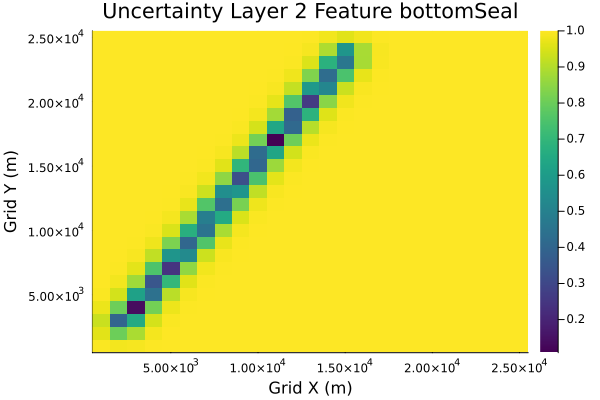

In [52]:
# Taking a seismic line action first
curstate = rand(initialstate(pomdp))
step = POMDPs.gen(pomdp, curstate, all_actions[21], nothing)
println(typeof(step), "\nReward: ", step.r)
curstate = step.sp

println(curstate.rocktype_belief)
visualize_uncertainty(curstate, 2, FEATURE)

w/o scaling, For layer 1, column bottomSeal, 
mean uncertainty: 1.0 
with scaling factor: 1.0, mean uncertainty after scaling: 1.0
w/o scaling, For layer 1, column bottomSeal, 
mean uncertainty: 1.0 
with scaling factor: 1.0, mean uncertainty after scaling: 1.0
Action: well_action, 
zzzAction Cost: -3, 
zzzUncertainty Change: 110.20156478178393, 
zzzSuitability: 1.09375
@NamedTuple{sp::CCSState, o::Vector{Any}, r::Float64}
Reward: 108.29531478178393
Categorical{Float64, Vector{Float64}}[Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 1.0, 0.0]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[1.0, 0.0, 0.0]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0]), Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[1.0, 0.0, 0.0])]


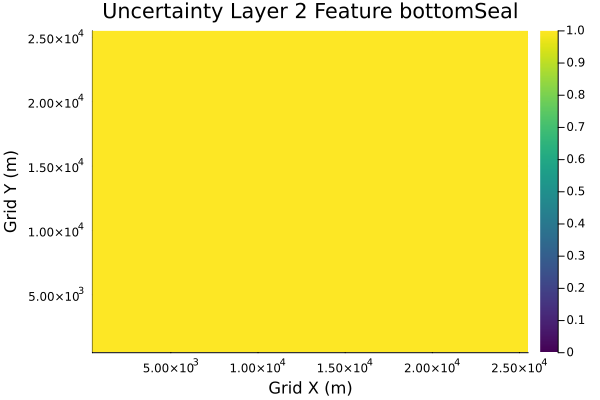

In [53]:
curstate = rand(initialstate(pomdp))
step = POMDPs.gen(pomdp, curstate, all_actions[2], nothing)
println(typeof(step), "\nReward: ", step.r)
curstate = step.sp

println(curstate.rocktype_belief)
visualize_uncertainty(curstate, 2, FEATURE)